# Modelling

In [19]:
df = spark.read.format("parquet")\
    .option("header","true")\
    .option("inferschema","true")\
    .load("s3://group23project/data_processing/")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
from pyspark.sql.functions import col
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Train Test Split

- The train-test split procedure is used to estimate the performance of machine learning algorithms when they 
    are used to make predictions on data not used to train the model.
- A train set is used for training the model.
- A test set that is used to evaluate the final model accuracy before deployment.
- Our data is from 2009 to 2018 and we test model on latest data which is 2018.
- Test data set is 11.7% of full data

In [21]:
#train test split
trainDF = df.where(col("YEAR")!=2018)
testDF = df.where(col("YEAR")==2018)

# print the count of observations in each set
print("Observations in training set = ", trainDF.count())
print("Observations in testing set = ", testDF.count())


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Observations in training set =  53359203
Observations in testing set =  7071817

# Modelling

- We are using Multilayer Perceptron Classifier algorithm for this project.
- A Perceptron(neuron) is a neural network unit that does certain computations to detect features
    or business intelligence in the input data.
- A Perceptron consists of input values, weights and a bias, a weighted sum and activation function.
- Perceptrons are the building blocks of neural networks. It is typically used for supervised learning.


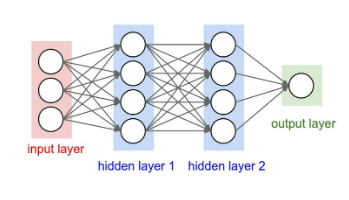

 - An attempt to process information using artificial neurons 
    in a way similar to biological neural system does.
 - An interconnected group of artificial neurons that uses 
    mathematical model to solve the given problem.


In [12]:
# Building MultilayerPerceptronClassifier object.
mlp = MultilayerPerceptronClassifier(layers = [8,5,5,2],featuresCol='scaledfeatures', labelCol='FLIGHT_STATUS')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# fit the MultilayerPerceptronClassifier object on the training data.
mlp_model = mlp.fit(trainDF)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
#This MultilayerPerceptronClassifier can be used as a transformer to perform prediction on the testing data.
pred_df = mlp_model.transform(testDF)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Evaluating Model

# Accuracy

- Accuracy is the number of correctly predicted data points out of all the data points.
- Doesn’t work well with imbalance dataset.


# F1 score
- It is the harmonic mean of precision and recall. This takes the contribution of both, precision as well as recall


In [15]:
# Build the MulticlassClassificationEvaluator object 'evaluator'.
# 1. Accuracy.
evaluator = MulticlassClassificationEvaluator(labelCol = 'FLIGHT_STATUS', predictionCol = 'prediction', metricName = 'accuracy')
# 2. F1 Score (F-measure).
evaluator2 = MulticlassClassificationEvaluator(labelCol = 'FLIGHT_STATUS', predictionCol = 'prediction', metricName = 'f1')
mlpacc = evaluator.evaluate(pred_df)
mlpf1=evaluator2.evaluate(pred_df)
print("accuracy:",mlpacc)
print('f1:', mlpf1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

accuracy: 0.6755891731926886
f1: 0.6288222461885589

# Confusion matrix

- It’s just a representation of the TP, FP, TN, FN parameters in a matrix format.
- True positives (TP): Predicted positive and are actually positive.
- False positives (FP): Predicted positive and are actually negative.
- True negatives (TN): Predicted negative and are actually negative.
- False negatives (FN): Predicted negative and are actually positive.


In [24]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F

preds_and_labels = pred_df.select(['prediction','FLIGHT_STATUS']).withColumn('FLIGHT_STATUS', F.col('FLIGHT_STATUS').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','FLIGHT_STATUS'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[4212855.  421912.]
 [1872262.  564788.]]

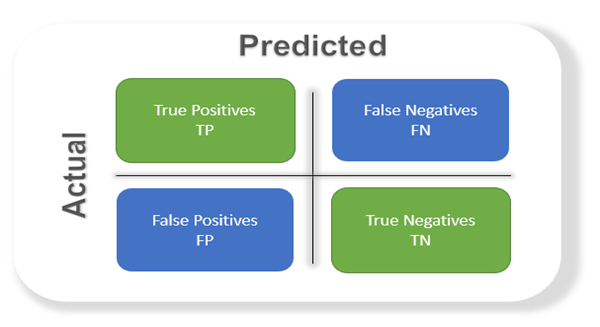

In [16]:
mlp_model.save("s3://group23project/model/multilayerperceptron.h5")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…